In [23]:
import matplotlib.pyplot as plt

import pandas as pd

import os
import numpy as np

In [24]:
PATH_TO_DATA = os.path.join(".", "dataset")

## Load the dataset

To run this notebook, first download the Physical Therapy Exercises dataset (http://dx.doi.org/10.13140/RG.2.2.20101.01768), 
and place it under the `./dataset/` directory.

In [25]:
subjects  = range(1, 6)
exercises = range(1, 9)
relevant_imus = np.array([2, 4, 2, 2, 2, 2, 2, 2])

df = pd.DataFrame(columns=['subject', 'exercise', 'imu', 'ts'])

for subject in subjects:
    for exercise, imu in zip(exercises, relevant_imus):

        path = os.path.join(PATH_TO_DATA, f"s{subject}", f"e{exercise}", f"u{imu}", "test.txt")
        if not os.path.exists(path):
            continue

        f = open(path)
        next(f)
        
        data = np.array([l.split(';') for l in f.readlines()], dtype=np.float64)
        # acc (3 spatial axes), gyr (3 spatial axes), mag (3 spatial axes)
        df.loc[len(df.index)] = [subject, exercise, imu, data[:, 1:]] 

        f.close()

df.head()

,subject,exercise,imu,ts
0,1,1,2,"[[-9.268303, 2.981149, 0.738239, -0.0084, 0.01..."
1,1,2,4,"[[8.949058, 1.226986, 3.799527, 0.004876, -0.0..."
2,1,3,2,"[[1.86029, 9.445716, 2.018317, 0.008508, 0.019..."
3,1,4,2,"[[-1.044785, -2.41039, 9.390947, -0.008478, 0...."
4,1,5,2,"[[-0.919127, -7.623193, 6.012549, 0.004559, 0...."


## Preprocessing

In [26]:
# znormalize time series of imu by the std of the different sensors (acc, gyr, mag)
def znormalize(ts):
    for i in range(3):
        ts[:, 3*i : 3*(i+1)] = (ts[:, 3*i : 3*(i+1)] - np.mean(ts[:, 3*i : 3*(i+1)], axis=None)) / np.std(ts[:, 3*i : 3*(i+1)], axis=None)
    return ts

In [27]:
df['ts'] = df['ts']
# Only accelerometer data
df['ts'] = df['ts'].apply(lambda ts: ts[:, :3])

## Finding the idle periods and the possible start- and endpoints

In [28]:
import locomotif.locomotif as locomotif
import locomotif.visualize as visualize

def get_idle_mask(ts, window_size, threshold):
    if window_size % 2 == 0:
        window_size += 1
    
    n, _ = ts.shape    
    idle = np.full(n, False)
    
    half_window = window_size // 2
    for center in range(half_window, n-half_window):
        window_start = center-half_window
        window_end   = center+half_window+1
        if np.all(np.var(ts[window_start:window_end, :], axis=0) < threshold):
            idle[window_start:window_end] = True
    return idle

In [29]:
def get_start_mask(ts, idle_mask, quantile):    
    # mean of the idle values
    idle_mean  = np.mean(ts[idle_mask, :], axis=0)
    
    # determine the distance threshold
    distances          = np.sum((ts[~idle_mask] - idle_mean) ** 2, axis=1)
    distance_threshold = np.quantile(distances, quantile)

    # construct the start mask
    start_mask = (np.sum((ts - idle_mean) ** 2, axis=1) <= distance_threshold)
    start_mask[idle_mask] = False
    return start_mask.astype(bool)

## Applying LoCoMotif

In [30]:
def apply_locomotif_physiotherapy(ts, l_min, l_max, rho, nb_motifs, overlap=0.25, warping=True):
    # Find idle segments and start- and endmask
    idle_mask  = get_idle_mask(ts, l_max, 0.005)
    start_mask = get_start_mask(ts, idle_mask, 0.33)
    end_mask   = start_mask
    
    gamma = 1.0
    ts = ts.astype(np.float32)
    # Determine rho based on the non-idle samples
    am = locomotif.similarity_matrix_ndim(ts, ts, gamma, only_triu=True)
    am[np.tril_indices(len(am), k=-1)] = np.nan
    tau = np.nanquantile(am[~idle_mask, :][:, ~idle_mask], rho, axis=None)
    print(tau)

    # Apply LoCoMotif
    lcm = locomotif.LoCoMotif(ts=ts, gamma=gamma, tau=tau, delta_a=2*tau, delta_m=0.5, l_min=l_min, l_max=l_max, step_sizes=np.array([(1, 1), (2, 1), (1, 2)]) if warping else np.array([(1, 1)]))
    lcm.align()
    lcm.find_best_paths(vwidth=l_min // 2)
    motif_sets = []
    for repr, motif_set, _ in lcm.find_best_motif_sets(nb=nb_motifs, overlap=overlap, start_mask=start_mask, end_mask=end_mask):
        motif_sets.append((repr, motif_set))
    return lcm, motif_sets

Subject 1, Exercise 1, IMU 2


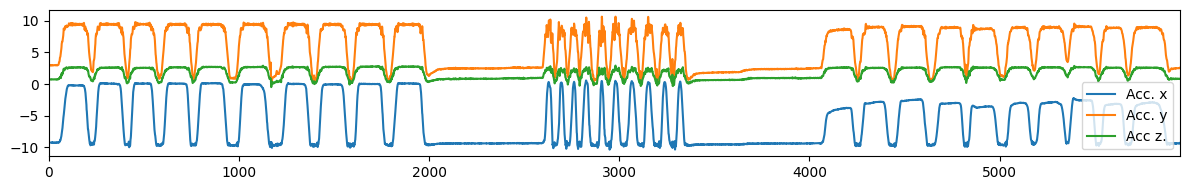

In [31]:
subject   = 1
exercise  = 1
imu       = 2

print(f"Subject {subject}, Exercise {exercise}, IMU {imu}")
*_, ts = df_example = df.query('subject == @subject & exercise == @exercise & imu == @imu').iloc[0]
fig, ax = visualize.plot_motif_sets(ts, [], {}, dimension_names=['Acc. x', 'Acc. y', 'Acc z.'])

0.1342020958662033


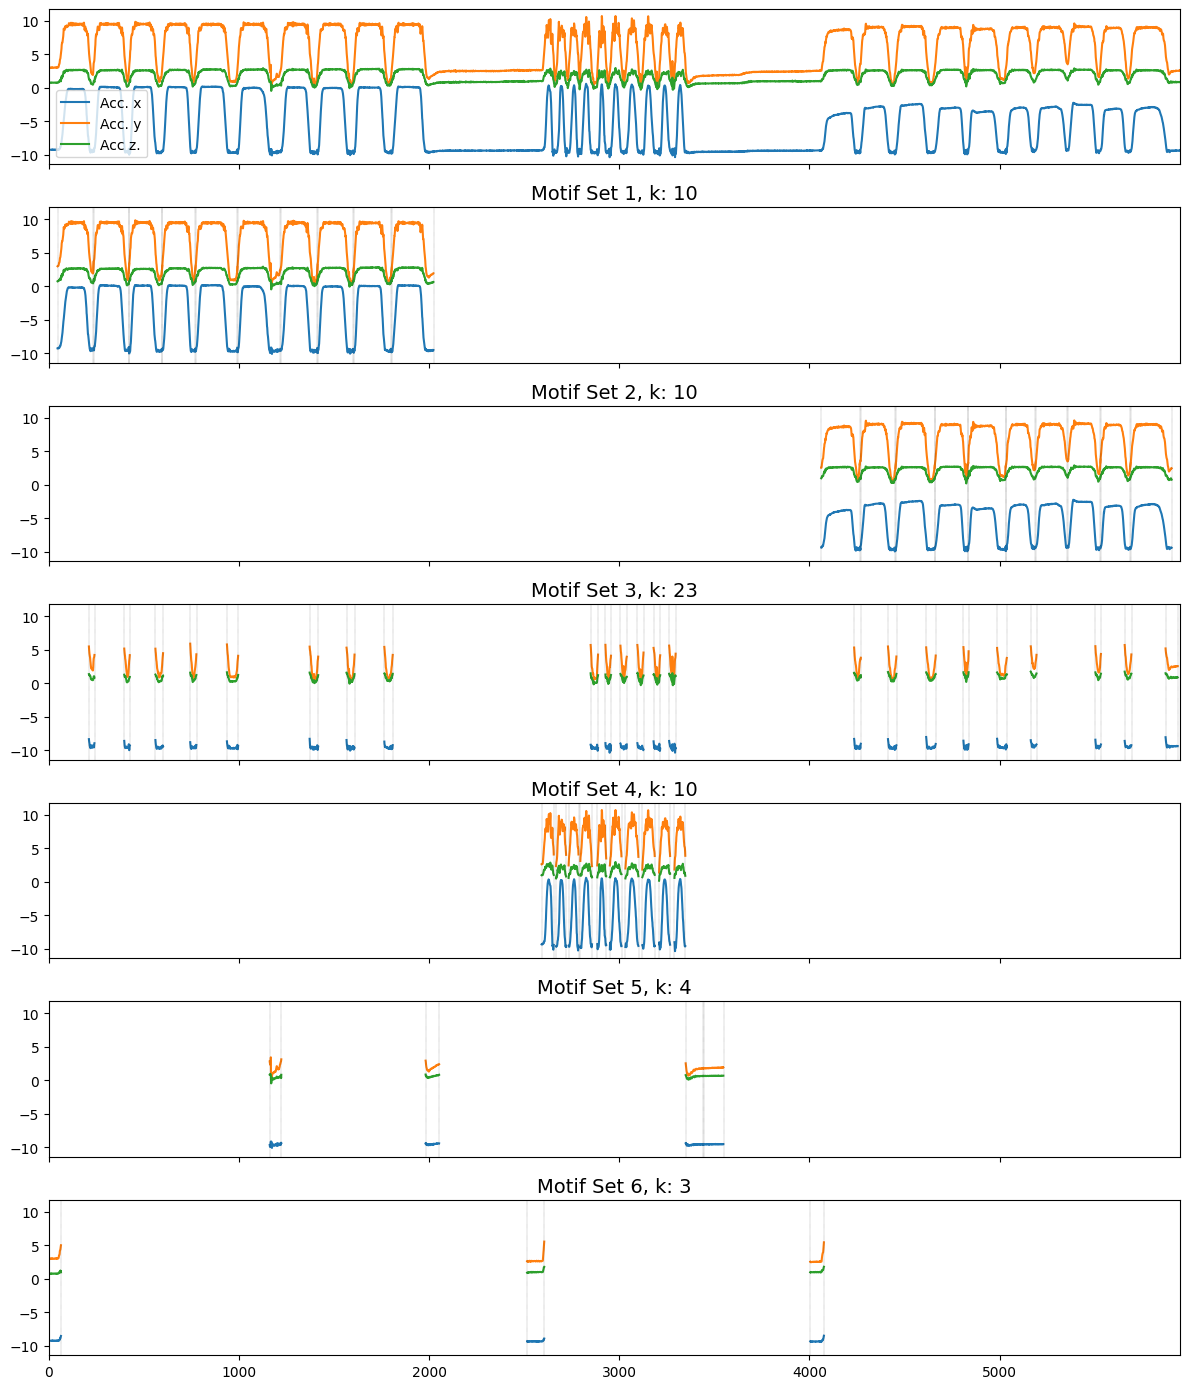

In [32]:
rho       = 0.8
nb_motifs = 6
overlap   = 0.25

l_min = 51
l_max = 262

lcm, motif_sets = apply_locomotif_physiotherapy(ts, l_min, l_max, rho, nb_motifs, overlap=overlap, warping=True)
fig, ax = visualize.plot_motif_sets(ts, motif_sets, {}, dimension_names=['Acc. x', 'Acc. y', 'Acc z.'])

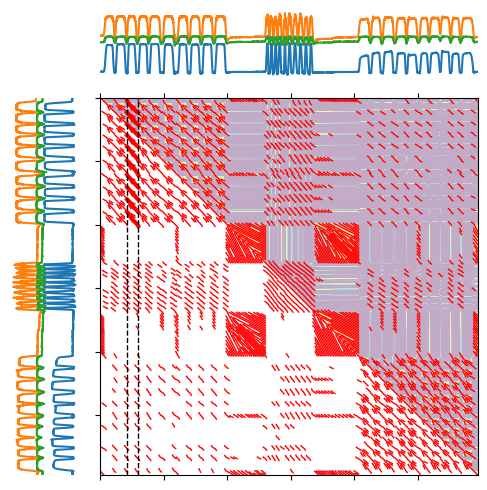

In [33]:
# b, e, fitness, coverage, score
import locomotif.visualize as visualize

(b, e), motif_set = motif_sets[0]

fig, axs, _ = visualize.plot_sm(ts, ts, lcm._sm, matshow_kwargs={'alpha': 0.33})
visualize.plot_local_warping_paths(axs, lcm.get_paths(), lw=1)

induced_paths = lcm.induced_paths(b, e)
visualize.plot_local_warping_paths(axs, induced_paths, lw=3)

axs[3].axvline(b, lw=1, c='k', ls='--')
axs[3].axvline(e, lw=1, c='k', ls='--')